# Classification with team game scores

In the previous notebook "Analyzing importance of game scores-June19", we found that classifying winning by the sum of game scores was $97\%$ accurate. More specifically, for each game, we calculated the Hollinger Game Score for each player on each team and found the sum of these game scores by team. We then predicted winning by which team had a higher game score.

Recall that the Hollinger Game Score is calculated by:

$
PTS + 0.4 * FG - 0.7 * FGA - 0.4*(FTA - FT) + 0.7 * ORB + 0.3 * DRB + STL + 0.7 * AST + 0.7 * BLK - 0.4 * PF - TOV,
$

where each is an individual stat for the player. Here, the abbreviations are
- `PTS`, number of points scored.
- `FG`, field goals made.
- `FGA`, field goals attempted.
- `FTA`, free throws attempted.
- `FT`, free throws made.
- `ORB`, offensive rebounds.
- `DRB`, defensive rebounds.
- `STL`, steals.
- `AST`, assists.
- `BLK`, blocks.
- `PF`, personal fouls.
- `TOV`, turnovers.

But note that the sum of the player stats equal the corresponding team stats. Thus, it suffices to consider the team stats for each team. In this notebook, we will see how accurate classifying by this score was for the 2017-2018 season.

In [1]:
#setting up notebook

% matplotlib inline


#necessary libraries
import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
from pandas.util.testing import assert_frame_equal
pd.options.mode.chained_assignment = None  # default='warn'



import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

from datetime import datetime
import time
from nose.tools import assert_equal

import sqlite3

## Importing team stats info

We begin by analyzing the 2017-2018 season team stats data. We will import 'all_team_stats_2009_to_2018.csv', which contains team stats data for every game since the 2009-2010 season. We will then filter to the 2017-2018 data. To do this, we will employ SQL because our team stats DataFrame doesn't include info on which year each game occurs. Thus, we will also need to import 'all_games_04_on'. We conclude by separating out the home and team stats into two DataFrames.

In [2]:
#import all team stats data
team_stats_df = pd.read_csv('all_team_stats_2009_to_2018.csv').loc[:,'team':]

team_stats_df.head()

,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,DAL,21,23,25,27,96,39,78,50.0,9,23,39.1,9,10,90.0,52,8,39,21,2,4,28,8,8,0,16,1,0,0,[],1,Away,281217028
1,TOR,33,16,14,23,86,36,84,42.9,4,11,36.4,10,13,76.9,39,7,30,17,7,4,12,17,8,0,14,0,0,0,[],0,Home,281217028
2,GS,26,19,17,26,88,36,90,40.0,5,21,23.8,11,13,84.6,48,10,31,13,6,6,32,6,10,38,21,1,0,0,[],0,Away,290304004
3,CHI,20,31,24,35,110,39,86,45.3,5,8,62.5,27,32,84.4,60,17,37,19,7,7,26,24,18,46,16,0,0,0,[],1,Home,290304004
4,MIL,20,19,19,15,73,28,75,37.3,4,18,22.2,13,14,92.9,46,8,33,19,7,3,36,13,10,24,23,0,0,0,[],0,Away,290304005


In [3]:
#set up SQL
home_dir = !echo $HOME

#Define data directory
database_dir = home_dir[0] + '/database'

print(f'Database will persist at {database_dir}\n')

Database will persist at /Users/derekjung/database



In [4]:
%%bash -s "$database_dir"

#passed Python variable, later accessed with $1

#check if directory exists
if [ -d "$1" ] ; then

    echo "Directory already exists."

else
    #otherwise grapb file from Internet and store locally in data directory
    
    mkdir $1
    echo "creating database directory"

fi

Directory already exists.


In [5]:
con = sqlite3.connect("stats_June20.db")

cur = con.cursor()

In [6]:
team_stats_df.to_sql(name='team_stats_tb', con=con, if_exists='replace',\
                          index=False, chunksize=1000)

#view some of game info table
sql_game_access = "\
SELECT * \
FROM team_stats_tb \
LIMIT 3 \
"

cur.execute(sql_game_access)

for row in cur:
    print(row)

('DAL', 21, 23, 25, 27, 96, 39, 78, 50.0, 9, 23, 39.1, 9, 10, 90.0, 52, 8, 39, 21, 2, 4, 28, 8, 8, 0, 16, 1, 0, 0, '[]', 1, 'Away', 281217028)
('TOR', 33, 16, 14, 23, 86, 36, 84, 42.9, 4, 11, 36.4, 10, 13, 76.9, 39, 7, 30, 17, 7, 4, 12, 17, 8, 0, 14, 0, 0, 0, '[]', 0, 'Home', 281217028)
('GS', 26, 19, 17, 26, 88, 36, 90, 40.0, 5, 21, 23.8, 11, 13, 84.6, 48, 10, 31, 13, 6, 6, 32, 6, 10, 38, 21, 1, 0, 0, '[]', 0, 'Away', 290304004)


In [7]:
#find games by Matchup ID for Warriors season#find g 
all_game_info = pd.read_csv('all_games_04_on.csv').loc[:,'team':]


#restrict to 2017-2018 season
season_year_bool = all_game_info['season_end_year'] == 2018

all_game_info_18 = all_game_info[season_year_bool]

all_game_info_18.head()

,team,season_start_year,season_end_year,season_type,game_month,game_day,game_year,game_date,matchup_id
31336,bos,2017,2018,regular,10,17,2017,10/17/2017,400974437
31337,bos,2017,2018,regular,10,18,2017,10/18/2017,400974703
31338,bos,2017,2018,regular,10,20,2017,10/20/2017,400974772
31339,bos,2017,2018,regular,10,24,2017,10/24/2017,400974802
31340,bos,2017,2018,regular,10,26,2017,10/26/2017,400974818


In [8]:
all_game_info_18.to_sql(name='game_info_18_tb', con=con, if_exists='replace',\
                          index=False, chunksize=1000)

#view some of game info table
sql_game_access = "\
SELECT * \
FROM game_info_18_tb \
LIMIT 3 \
"

cur.execute(sql_game_access)

for row in cur:
    print(row)

('bos', 2017, 2018, 'regular', 10, 17, 2017, '10/17/2017', 400974437)
('bos', 2017, 2018, 'regular', 10, 18, 2017, '10/18/2017', 400974703)
('bos', 2017, 2018, 'regular', 10, 20, 2017, '10/20/2017', 400974772)


In [9]:
sql_team_stats_18_join = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.* \
FROM game_info_18_tb AS game_tb \
JOIN team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
LIMIT 5 \
"

cur.execute(sql_team_stats_18_join)

for row in cur:
    print(row)

(2018, 'regular', '10/17/2017', 400974437, 'BOS', 19, 19, 33, 28, 99, 36, 88, 40.9, 8, 32, 25.0, 19, 25, 76.0, 52, 9, 37, 24, 11, 4, 12, 15, 16, 42, 24, 3, 0, 0, '[]', 0, 'Away', 400974437)
(2018, 'regular', '10/17/2017', 400974437, 'CLE', 29, 25, 18, 30, 102, 38, 83, 45.8, 5, 22, 22.7, 21, 25, 84.0, 55, 9, 41, 19, 3, 4, 17, 24, 11, 50, 25, 2, 0, 0, '[]', 1, 'Home', 400974437)
(2018, 'regular', '10/18/2017', 400974703, 'BOS', 26, 27, 27, 20, 100, 39, 91, 42.9, 11, 28, 39.3, 11, 21, 52.4, 54, 11, 32, 23, 12, 2, 15, 16, 6, 50, 27, 1, 0, 0, '[]', 0, 'Home', 400974703)
(2018, 'regular', '10/18/2017', 400974703, 'MIL', 24, 34, 18, 32, 108, 38, 76, 50.0, 7, 21, 33.3, 25, 30, 83.3, 51, 6, 39, 19, 6, 4, 15, 17, 4, 56, 22, 1, 0, 0, '[]', 1, 'Away', 400974703)
(2018, 'regular', '10/20/2017', 400974772, 'BOS', 24, 22, 23, 33, 102, 35, 84, 41.7, 10, 29, 34.5, 22, 32, 68.8, 64, 14, 41, 16, 4, 5, 19, 16, 0, 28, 24, 0, 0, 0, '[]', 1, 'Away', 400974772)


We separate out the team stats for the away and home teams and save them in two DataFrames.

In [10]:
sql_team_stats_18_away = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.* \
FROM game_info_18_tb AS game_tb \
JOIN team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
WHERE team_tb.away_or_home = 'Away' \
"

#all team stats for away team
team_stats_18_away = pd.read_sql(sql_team_stats_18_away, con)

team_stats_18_away.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,3/29/2018,400975872,OKC,29,27,25,18,99,37,85,43.5,11,30,36.7,14,21,66.7,52,10,33,19,11,3,15,22,22,42,23,0,0,0,[],0,Away,400975872
1,2018,regular,3/29/2018,400975873,IND,28,33,18,27,106,40,80,50.0,8,26,30.8,18,20,90.0,38,7,27,23,9,4,10,15,10,50,17,0,0,0,[],1,Away,400975873
2,2018,regular,3/29/2018,400975874,MIL,29,29,34,24,116,48,87,55.2,11,20,55.0,9,10,90.0,42,7,29,30,16,3,16,29,21,56,17,0,0,0,[],1,Away,400975874
3,2018,regular,3/30/2018,400975875,CHI,30,27,9,24,90,30,84,35.7,14,41,34.1,16,23,69.6,65,11,42,16,11,7,17,19,14,24,17,0,0,0,[],1,Away,400975875
4,2018,regular,3/30/2018,400975876,PHI,30,17,39,15,101,42,95,44.2,8,38,21.1,9,13,69.2,59,9,44,34,10,6,15,11,16,38,18,0,0,0,[],1,Away,400975876


In [11]:
sql_team_stats_18_home = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.* \
FROM game_info_18_tb AS game_tb \
JOIN team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
WHERE team_tb.away_or_home = 'Home' \
"

#all team stats for home teams
team_stats_18_home = pd.read_sql(sql_team_stats_18_home, con)

team_stats_18_home.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,3/29/2018,400975872,SA,24,35,18,26,103,34,81,42.0,13,31,41.9,22,30,73.3,58,14,34,22,13,6,18,17,22,26,18,0,0,0,[],1,Home,400975872
1,2018,regular,3/29/2018,400975873,SAC,28,28,23,24,103,42,78,53.8,13,31,41.9,6,9,66.7,43,6,26,27,3,2,18,19,8,42,24,0,0,0,[],0,Home,400975873
2,2018,regular,3/29/2018,400975874,GS,27,22,23,35,107,41,75,54.7,10,20,50.0,15,15,100.0,32,2,29,26,10,7,19,23,23,46,19,3,0,0,[],0,Home,400975874
3,2018,regular,3/30/2018,400975875,ORL,24,20,25,13,82,31,94,33.0,7,39,17.9,13,14,92.9,60,12,43,16,11,5,13,14,8,40,18,0,0,0,[],0,Home,400975875
4,2018,regular,3/30/2018,400975876,ATL,27,14,18,32,91,36,101,35.6,9,39,23.1,10,15,66.7,68,15,44,24,9,4,17,17,13,40,14,0,0,0,[],0,Home,400975876


## Game Scores

We now calculate the team game scores for each team. This will be calculated in the same way, except for the team instead of for each player:

$
PTS + 0.4 * FG - 0.7 * FGA - 0.4*(FTA - FT) + 0.7 * ORB + 0.3 * DRB + STL + 0.7 * AST + 0.7 * BLK - 0.4 * PF - TOV.
$

In [12]:
def  hollinger_game_score(row):
    '''
    Calculates Hollinger Game Score for a player's performance in a game.
    
    Input:
    row: row of DataFrame
    
    Output:
    float: game score for player
    '''
    
    game_score = row['total_points'] + 0.4*row['fg_made'] - 0.7*row['fg_attempted'] \
                - 0.4*(row['ft_attempted']-row['ft_made']) + 0.7*row['offensive_rebounds'] \
                + 0.3*row['defensive_rebounds'] + row['steals'] + 0.7*row['assists'] \
                + 0.7*row['blocks'] -0.4*row['personal_fouls'] - row['total_turnovers']
            
    return game_score

In [13]:
#add game score column to each team row

team_stats_18_away.loc[:,'game_score'] = team_stats_18_away.apply(hollinger_game_score, axis=1)
team_stats_18_home.loc[:,'game_score'] = team_stats_18_home.apply(hollinger_game_score, axis=1)

In [14]:
print(team_stats_18_away.shape)

team_stats_18_away.head()

(1312, 38)


,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id,game_score
0,2018,regular,3/29/2018,400975872,OKC,29,27,25,18,99,37,85,43.5,11,30,36.7,14,21,66.7,52,10,33,19,11,3,15,22,22,42,23,0,0,0,[],0,Away,400975872,70.6
1,2018,regular,3/29/2018,400975873,IND,28,33,18,27,106,40,80,50.0,8,26,30.8,18,20,90.0,38,7,27,23,9,4,10,15,10,50,17,0,0,0,[],1,Away,400975873,89.3
2,2018,regular,3/29/2018,400975874,MIL,29,29,34,24,116,48,87,55.2,11,20,55.0,9,10,90.0,42,7,29,30,16,3,16,29,21,56,17,0,0,0,[],1,Away,400975874,103.8
3,2018,regular,3/30/2018,400975875,CHI,30,27,9,24,90,30,84,35.7,14,41,34.1,16,23,69.6,65,11,42,16,11,7,17,19,14,24,17,0,0,0,[],1,Away,400975875,64.0
4,2018,regular,3/30/2018,400975876,PHI,30,17,39,15,101,42,95,44.2,8,38,21.1,9,13,69.2,59,9,44,34,10,6,15,11,16,38,18,0,0,0,[],1,Away,400975876,85.0


In [15]:
print(team_stats_18_home.shape)

team_stats_18_home.head()

(1312, 38)


,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id,game_score
0,2018,regular,3/29/2018,400975872,SA,24,35,18,26,103,34,81,42.0,13,31,41.9,22,30,73.3,58,14,34,22,13,6,18,17,22,26,18,0,0,0,[],1,Home,400975872,84.1
1,2018,regular,3/29/2018,400975873,SAC,28,28,23,24,103,42,78,53.8,13,31,41.9,6,9,66.7,43,6,26,27,3,2,18,19,8,42,24,0,0,0,[],0,Home,400975873,71.7
2,2018,regular,3/29/2018,400975874,GS,27,22,23,35,107,41,75,54.7,10,20,50.0,15,15,100.0,32,2,29,26,10,7,19,23,23,46,19,3,0,0,[],0,Home,400975874,87.5
3,2018,regular,3/30/2018,400975875,ORL,24,20,25,13,82,31,94,33.0,7,39,17.9,13,14,92.9,60,12,43,16,11,5,13,14,8,40,18,0,0,0,[],0,Home,400975875,55.0
4,2018,regular,3/30/2018,400975876,ATL,27,14,18,32,91,36,101,35.6,9,39,23.1,10,15,66.7,68,15,44,24,9,4,17,17,13,40,14,0,0,0,[],0,Home,400975876,62.4


In [16]:
#check that away and home team stats align by row with same games
team_stats_18_away.loc[:,'game_matchup_id'].equals(team_stats_18_home.loc[:,'game_matchup_id'])

True

## Create DataFrames of differences

We now create two DataFrames: one for home teams and one for away teams. Their columns will be:

- `season_end_year`, final year of season.
- `season_type`, regular season or postseason game.
- `game_date`, date of game.
- `game_matchup_id`, Matchup ID for game.
- `team`, the home team for home team DataFrame and the away team for away team DataFrame.
- `away_or_home`, whether team is away or home team.
- `won`, 1 if team won, 0 otherwise.
- `game_score`, game score of team.
- `game_score_opp`, game score of opponents.
- `game_score_diff`, team game score minus opponent game score.
- `pred_win`, 1 if game score higher than opponent's team score, 0 therwise.

In [17]:
#column names for difference DataFrames
column_names_diff = ['season_end_year', 'season_type', 'game_date', \
                    'game_matchup_id', 'team', 'away_or_home', 'won', \
                    'game_score', 'game_score_opp', 'game_score_diff', 'pred_win']

game_score_idx = column_names_diff.index('game_score')

#column names to take out from home and away team stat DataFrames
slice_column_names = column_names_diff[:game_score_idx+1]

print(slice_column_names)

['season_end_year', 'season_type', 'game_date', 'game_matchup_id', 'team', 'away_or_home', 'won', 'game_score']


In [18]:
#DataFrames that have differences of game scores
team_stats_18_home_diff = team_stats_18_home[slice_column_names]
team_stats_18_away_diff = team_stats_18_away[slice_column_names]

In [19]:
team_stats_18_home_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score
0,2018,regular,3/29/2018,400975872,SA,Home,1,84.1
1,2018,regular,3/29/2018,400975873,SAC,Home,0,71.7
2,2018,regular,3/29/2018,400975874,GS,Home,0,87.5
3,2018,regular,3/30/2018,400975875,ORL,Home,0,55.0
4,2018,regular,3/30/2018,400975876,ATL,Home,0,62.4


In [20]:
team_stats_18_away_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score
0,2018,regular,3/29/2018,400975872,OKC,Away,0,70.6
1,2018,regular,3/29/2018,400975873,IND,Away,1,89.3
2,2018,regular,3/29/2018,400975874,MIL,Away,1,103.8
3,2018,regular,3/30/2018,400975875,CHI,Away,1,64.0
4,2018,regular,3/30/2018,400975876,PHI,Away,1,85.0


In [21]:
#append opponent game score
team_stats_18_home_diff.loc[:,'game_score_opp'] = team_stats_18_away_diff.loc[:,'game_score']
team_stats_18_away_diff.loc[:,'game_score_opp'] = team_stats_18_home_diff.loc[:,'game_score']

In [22]:
team_stats_18_home_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp
0,2018,regular,3/29/2018,400975872,SA,Home,1,84.1,70.6
1,2018,regular,3/29/2018,400975873,SAC,Home,0,71.7,89.3
2,2018,regular,3/29/2018,400975874,GS,Home,0,87.5,103.8
3,2018,regular,3/30/2018,400975875,ORL,Home,0,55.0,64.0
4,2018,regular,3/30/2018,400975876,ATL,Home,0,62.4,85.0


In [23]:
team_stats_18_away_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp
0,2018,regular,3/29/2018,400975872,OKC,Away,0,70.6,84.1
1,2018,regular,3/29/2018,400975873,IND,Away,1,89.3,71.7
2,2018,regular,3/29/2018,400975874,MIL,Away,1,103.8,87.5
3,2018,regular,3/30/2018,400975875,CHI,Away,1,64.0,55.0
4,2018,regular,3/30/2018,400975876,PHI,Away,1,85.0,62.4


In [24]:
#compute differences of game scores
team_stats_18_home_diff.loc[:,'game_score_diff'] \
    = team_stats_18_home_diff.loc[:,'game_score'] - team_stats_18_home_diff.loc[:,'game_score_opp']

team_stats_18_away_diff.loc[:,'game_score_diff'] \
    = team_stats_18_away_diff.loc[:,'game_score'] - team_stats_18_away_diff.loc[:,'game_score_opp']


In [25]:
team_stats_18_home_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp,game_score_diff
0,2018,regular,3/29/2018,400975872,SA,Home,1,84.1,70.6,13.5
1,2018,regular,3/29/2018,400975873,SAC,Home,0,71.7,89.3,-17.6
2,2018,regular,3/29/2018,400975874,GS,Home,0,87.5,103.8,-16.3
3,2018,regular,3/30/2018,400975875,ORL,Home,0,55.0,64.0,-9.0
4,2018,regular,3/30/2018,400975876,ATL,Home,0,62.4,85.0,-22.6


In [26]:
team_stats_18_away_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp,game_score_diff
0,2018,regular,3/29/2018,400975872,OKC,Away,0,70.6,84.1,-13.5
1,2018,regular,3/29/2018,400975873,IND,Away,1,89.3,71.7,17.6
2,2018,regular,3/29/2018,400975874,MIL,Away,1,103.8,87.5,16.3
3,2018,regular,3/30/2018,400975875,CHI,Away,1,64.0,55.0,9.0
4,2018,regular,3/30/2018,400975876,PHI,Away,1,85.0,62.4,22.6


In [27]:
#check each home game score is opposite away game score
team_stats_18_home_diff.loc[:,'game_score_diff'].equals(-team_stats_18_away_diff.loc[:,'game_score_diff'])

True

In [30]:
#predict win if higher game score, 0 if lower game score, 0.5 otherwise

team_stats_18_away_diff.loc[:,'pred_win'] = team_stats_18_away_diff.loc[:,'game_score_diff'].apply(lambda x: 1 if x>0 else (0 if x<0 else 0.5))
team_stats_18_home_diff.loc[:,'pred_win'] = team_stats_18_home_diff.loc[:,'game_score_diff'].apply(lambda x: 1 if x>0 else (0 if x<0 else 0.5))

In [38]:
team_stats_18_away_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp,game_score_diff,pred_win
0,2018,regular,3/29/2018,400975872,OKC,Away,0,70.6,84.1,-13.5,0
1,2018,regular,3/29/2018,400975873,IND,Away,1,89.3,71.7,17.6,1
2,2018,regular,3/29/2018,400975874,MIL,Away,1,103.8,87.5,16.3,1
3,2018,regular,3/30/2018,400975875,CHI,Away,1,64.0,55.0,9.0,1
4,2018,regular,3/30/2018,400975876,PHI,Away,1,85.0,62.4,22.6,1


In [39]:
team_stats_18_home_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp,game_score_diff,pred_win
0,2018,regular,3/29/2018,400975872,SA,Home,1,84.1,70.6,13.5,1
1,2018,regular,3/29/2018,400975873,SAC,Home,0,71.7,89.3,-17.6,0
2,2018,regular,3/29/2018,400975874,GS,Home,0,87.5,103.8,-16.3,0
3,2018,regular,3/30/2018,400975875,ORL,Home,0,55.0,64.0,-9.0,0
4,2018,regular,3/30/2018,400975876,ATL,Home,0,62.4,85.0,-22.6,0


In [40]:
#see if any ties in game score
team_stats_18_away_diff.loc[:,'pred_win'].value_counts()

0    770
1    542
Name: pred_win, dtype: int64

There were no ties with game scores. We will now find how accurate predicting winning with game score is. We first combine the away and home DataFrames. We also generate a confusion matrix based on this classification.

In [48]:
team_stats_18_diff = pd.concat([team_stats_18_away_diff,team_stats_18_home_diff])

print('Number of team stats: ' + str(team_stats_18_diff.shape[0]))

team_stats_18_diff.head()

Number of team stats: 2624


,season_end_year,season_type,game_date,game_matchup_id,team,away_or_home,won,game_score,game_score_opp,game_score_diff,pred_win
0,2018,regular,3/29/2018,400975872,OKC,Away,0,70.6,84.1,-13.5,0
1,2018,regular,3/29/2018,400975873,IND,Away,1,89.3,71.7,17.6,1
2,2018,regular,3/29/2018,400975874,MIL,Away,1,103.8,87.5,16.3,1
3,2018,regular,3/30/2018,400975875,CHI,Away,1,64.0,55.0,9.0,1
4,2018,regular,3/30/2018,400975876,PHI,Away,1,85.0,62.4,22.6,1


In [49]:
from sklearn.metrics import accuracy_score, classification_report

score = 100*accuracy_score(team_stats_18_diff.loc[:,'won'], team_stats_18_diff.loc[:,'pred_win'])

print('Accuracy of classifying by team game score: {0:.2f}%'.format(score))

print(classification_report(team_stats_18_diff.loc[:,'won'], team_stats_18_diff.loc[:,'pred_win']))

Accuracy of classifying by team game score: 94.66%
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      1312
          1       0.95      0.95      0.95      1312

avg / total       0.95      0.95      0.95      2624



In [56]:
from sklearn.metrics import confusion_matrix

cfsn_matrix = confusion_matrix(team_stats_18_diff.loc[:,'won'], team_stats_18_diff.loc[:,'pred_win'], \
                labels=[1,0])

cfsn_matrix

array([[1242,   70],
       [  70, 1242]])

In [58]:
print('Number of games correctly classified: {0}'.format(cfsn_matrix[0,0]))
print('Number of games incorrectly classified: {0}'.format(cfsn_matrix[0,1]))

Number of games correctly classified: 1242
Number of games incorrectly classified: 70


We will conclude by producing the statistical summary of the team game scores. Note there is redundancy in these scores: a winning team will have the opposite game score difference as the losing team. Thus, we will only plot the scores for teams that won.

In [59]:
#restrict to teams that actually won
won_bool = team_stats_18_diff['won'] == 1
team_stats_18_diff_won = team_stats_18_diff[won_bool]

In [62]:
#check that all teams won in new DataFrame
assert_equal(set(team_stats_18_diff_won.loc[:,'won'])==set([1]), True)

#check that all games represented
assert_equal(team_stats_18_diff_won.shape[0],1312)

In [63]:
#summarize team game scores
team_stats_18_diff_won.loc[:,'game_score_diff'].describe()

count    1312.000000
mean       19.058460
std        14.464512
min       -11.200000
25%         9.100000
50%        16.800000
75%        27.000000
max        91.400000
Name: game_score_diff, dtype: float64

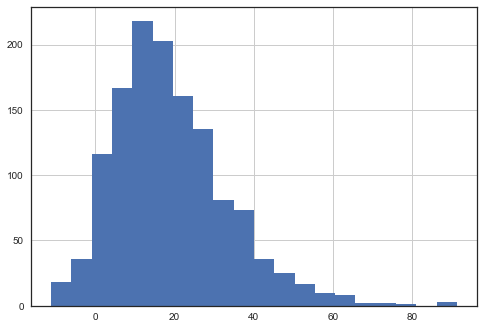

In [81]:
#draw histogram
game_score_diff = team_stats_18_diff_won.loc[:,'game_score_diff']

game_score_diff.hist(bins=20)

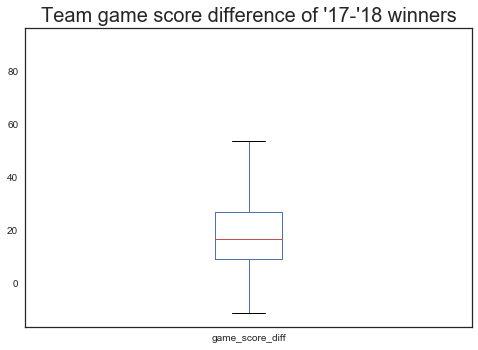

In [82]:
game_score_diff.plot('box', title="Team game score difference of '17-'18 winners")

We conclude by comparing the difference in game score with the difference in points. 

In [72]:
#find difference in points scored by away and home team
points_diff_18 = team_stats_18_home.loc[:,'total_points'] \
                - team_stats_18_away.loc[:,'total_points']
    
points_diff_18.head()

0     4
1    -3
2    -9
3    -8
4   -10
Name: total_points, dtype: int64

In [73]:
#margin of victory of winning team is absolute value
margin_18 = points_diff_18.apply(lambda x: abs(x))

margin_18.head()

0     4
1     3
2     9
3     8
4    10
Name: total_points, dtype: int64

In [75]:
#summary statistics of margin of victory
margin_summary = margin_18.describe()

margin_summary

count    1312.000000
mean       11.237043
std         8.214296
min         1.000000
25%         5.000000
50%         9.000000
75%        16.000000
max        61.000000
Name: total_points, dtype: float64

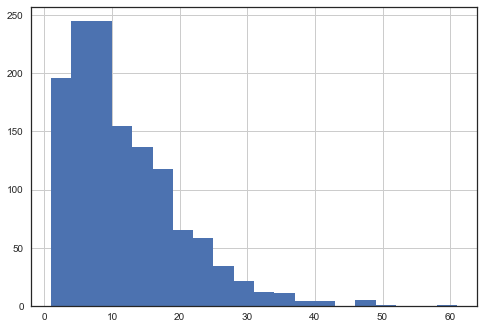

In [83]:
margin_18.hist(bins=20)

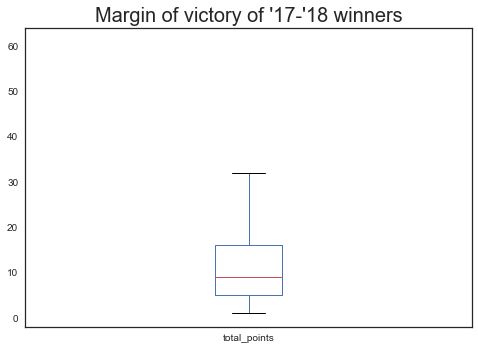

In [84]:
margin_18.plot(kind='box', title="Margin of victory of '17-'18 winners")

With an accuracy rate of over $94\%$ during the 2017-2018 season, classification by team game score deserves further exploration. 

Recall that team game score is a linear combination of several stats. We will explore which stat is most important for this classification. More specifically, we will consider the following few questions.

1. Which stat in the Hollinger Game Score is there the most prominant difference between winning teams and losing teams? 
2. Is it difference in points scored? If it is, how relatively important are other differences in stats?